In [1]:
import bilby
import numpy as np
import healpy as hp
import pandas as pd
import pylab
from astropy.table import Table
import astropy.cosmology as cosmo

name = 'HL2'
outdir = 'data/simlogs/'+name
bilby.core.utils.setup_logger(outdir=outdir)

duration = 4.0
sampling_frequency = 2048.0
minimum_frequency = 20

run_data = dict()

<h2>Pick a galaxy from the catalog and generate event parameters</h2>

In [2]:
catalog = Table.read('data/catalog_fullsky_zsm1.fits.gz').to_pandas()

ra = catalog['RA'].values
dec = catalog['DEC'].values
z = catalog['REDSHIFT'].values

mask = (z<0.2) & (ra>0) & (ra<360) & (np.abs(dec)<90)

ra = ra[mask] * np.pi / 180
dec = dec[mask] * np.pi / 180
z = z[mask]

cosmology = cosmo.WMAP7
bilby.gw.cosmology.set_cosmology(cosmology=cosmology)

dl = bilby.gw.conversion.redshift_to_luminosity_distance(z)

In [6]:
masses = np.random.uniform(25,35,2)
index = np.random.randint(0, len(z))
sindist = bilby.core.prior.Sine()
cosdist = bilby.core.prior.Cosine()

injection_parameters = dict(mass_1=np.max(masses),
                            mass_2=np.min(masses),
                            a_1=np.random.uniform(0, 0.99),
                            a_2=np.random.uniform(0, 0.99),
                            tilt_1=sindist.sample(),
                            tilt_2=sindist.sample(),
                            phi_12=np.random.uniform(0, 2*np.pi),
                            phi_jl=np.random.uniform(0, 2*np.pi),
                            luminosity_distance=dl[index],
                            theta_jn=sindist.sample(),
                            psi=np.random.uniform(0, np.pi),
                            phase=np.random.uniform(0, 2*np.pi),
                            geocent_time=np.random.uniform(1.1e9, 1.2e9),
                            ra=ra[index],
                            dec=dec[index]
                           )

run_data['index'] = index
run_data['id'] = name
for key in injection_parameters:
    run_data[key] = injection_parameters[key]

<h2>Uniform All-Sky Distribution Run</h2>

In [7]:
waveform_arguments = dict(waveform_approximant="IMRPhenomPv2",
                          reference_frequency=50.0,
                          minimum_frequency=minimum_frequency,
                          catch_waveform_errors=True
                         )

waveform_generator = bilby.gw.WaveformGenerator(duration=duration,
                                                sampling_frequency=sampling_frequency,
                                                frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
                                                parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
                                                waveform_arguments=waveform_arguments
                                               )

ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])

ifos.set_strain_data_from_power_spectral_densities(sampling_frequency=sampling_frequency,
                                                   duration=duration,
                                                   start_time=injection_parameters["geocent_time"] - 2
                                                  )

ifos.inject_signal(waveform_generator=waveform_generator, parameters=injection_parameters)

12:38 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
12:38 bilby INFO    : Injected signal in H1:
12:38 bilby INFO    :   optimal SNR = 54.31
12:38 bilby INFO    :   matched filter SNR = 55.59-0.79j
12:38 bilby INFO    :   mass_1 = 30.217311217519367
12:38 bilby INFO    :   mass_2 = 29.438553059882512
12:38 bilby INFO    :   a_1 = 0.7513861074949716
12:38 bilby INFO    :   a_2 = 0.6775246946853614
12:38 bilby INFO    :   tilt_1 = 0.4195402987370333
12:38 bilby INFO    :   tilt_2 = 0.9471592794232708
12:38 bilby INFO    :   phi_12 = 5.605047812344974
12:38 bilby INFO    :   phi_jl = 0.16950619973375008
12:38 bilby INFO    :   luminosity_distance = 373.0783085045788
12:38 bilby INFO    :   theta_jn = 1.9960130340723063
12:38 bilby INFO    :   psi = 0.7922942262461422
12:38 bilby INFO    :   phase

[{'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

In [8]:
prior = bilby.gw.prior.BBHPriorDict()
for key in ["mass_1",
            "mass_2",
            "a_1",
            "a_2",
            "tilt_1",
            "tilt_2",
            "theta_jn",
            "phi_12",
            "phi_jl",
            "psi",
            "phase",
           ]:
    prior[key] = injection_parameters[key]

prior["luminosity_distance"] = bilby.core.prior.PowerLaw(alpha=2, name='luminosity_distance', minimum=np.min(dl), maximum=1500, unit='Mpc', latex_label='$d_L$')
prior["geocent_time"] = bilby.core.prior.Uniform(injection_parameters['geocent_time']-0.1, injection_parameters['geocent_time']+0.1, name="geocent_time")
prior.pop("chirp_mass")
prior.pop("mass_ratio")

likelihood = bilby.gw.GravitationalWaveTransient(interferometers=ifos, waveform_generator=waveform_generator, priors=prior,
                                                 time_marginalization=True, phase_marginalization=False, distance_marginalization=True)

12:38 bilby INFO    : No prior given, using default BBH priors in /home/imcmahon/miniconda3/envs/igwn-py39/lib/python3.9/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.
12:38 bilby INFO    : Loaded distance marginalisation lookup table does not match for distance_array.
12:38 bilby INFO    : Building lookup table for distance marginalisation.


  0%|          | 0/400 [00:00<?, ?it/s]

In [9]:
result = bilby.run_sampler(likelihood=likelihood,
                           priors=prior,
                           sampler="dynesty",
                           npoints=2000,
                           injection_parameters=injection_parameters,
                           outdir=outdir,
                           label=name+'-injection-uniform',
                           conversion_function=bilby.gw.conversion.generate_all_bbh_parameters
                          )

12:39 bilby INFO    : Running for label 'HL1-injection-uniform', output will be saved to 'data/simlogs'
12:39 bilby INFO    : Using lal version 7.1.7
12:39 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
12:39 bilby INFO    : Using lalsimulation version 3.1.2
12:39 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.2;Id: 8c3a6977aa553c9a2019ec287a61dc5ee92087b4;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
12:39 bilby INFO    : Search parameters:
12:39 bilby INFO    :   dec = Cosine(minimum=-1.5707963267948966, maximum=1.5707963267948966, name='dec', latex_label='$\\mathrm{DEC}$', unit=None, boundary=None)
12:39 bilby INFO    :   ra = Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None, boundary=

0it [00:00, ?it/s]

12:39 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 2000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 1200, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fdf9d312c70>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
12:39 bilby INFO    : Checkpoint every check_point_delta_t = 600s
12:39 bilby INFO    : Using dynesty version 1.0.1
12:39 bilby INFO    : Using the b

14:25 bilby INFO    : Sampling time: 1:45:38.545783
14:25 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/35407 [00:00<?, ?it/s]

14:32 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/35407 [00:00<?, ?it/s]

14:32 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/35407 [00:00<?, ?it/s]

14:34 bilby INFO    : Summary of results:
nsamples: 35407
ln_noise_evidence: -11185.269
ln_evidence: -8020.145 +/-  0.115
ln_bayes_factor: 3165.124 +/-  0.115



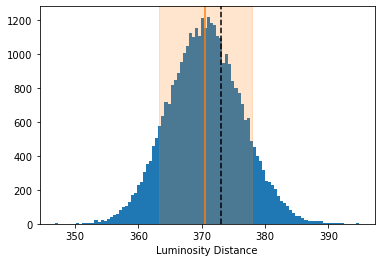

In [10]:
dl = result.posterior["luminosity_distance"].values
lower_bound = np.quantile(dl, 0.1)
upper_bound = np.quantile(dl, 0.9)
median = np.median(dl)
mean = np.mean(dl)
std = np.std(dl)

run_data['un_dl_med'] = median
run_data['un_dl_upper'] = upper_bound
run_data['un_dl_lower'] = lower_bound
run_data['un_dl_avg'] = mean
run_data['un_dl_std'] = std

fig, ax = pylab.subplots()
ax.hist(dl, bins=100)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax.axvline(median, color='C1')
ax.axvline(injection_parameters['luminosity_distance'], color='k', linestyle='--')
ax.set_xlabel("Luminosity Distance")
pylab.show()

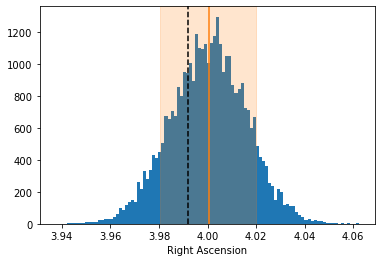

In [11]:
ra = result.posterior["ra"].values
lower_bound = np.quantile(ra, 0.1)
upper_bound = np.quantile(ra, 0.9)
median = np.median(ra)
mean = np.mean(ra)
std = np.std(ra)

run_data['un_ra_med'] = median
run_data['un_ra_upper'] = upper_bound
run_data['un_ra_lower'] = lower_bound
run_data['un_ra_avg'] = mean
run_data['un_ra_std'] = std

fig, ax = pylab.subplots()
ax.hist(ra, bins=100)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax.axvline(median, color='C1')
ax.axvline(injection_parameters['ra'], color='k', linestyle='--')
ax.set_xlabel("Right Ascension")
pylab.show()

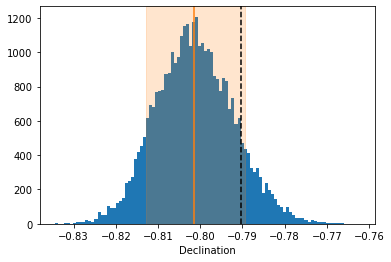

In [12]:
dec = result.posterior["dec"].values
lower_bound = np.quantile(dec, 0.1)
upper_bound = np.quantile(dec, 0.9)
median = np.median(dec)
mean = np.mean(dec)
std = np.std(dec)

run_data['un_dec_med'] = median
run_data['un_dec_upper'] = upper_bound
run_data['un_dec_lower'] = lower_bound
run_data['un_dec_avg'] = mean
run_data['un_dec_std'] = std

fig, ax = pylab.subplots()
ax.hist(dec, bins=100)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax.axvline(median, color='C1')
ax.axvline(injection_parameters['dec'], color='k', linestyle='--')
ax.set_xlabel("Declination")
pylab.show()

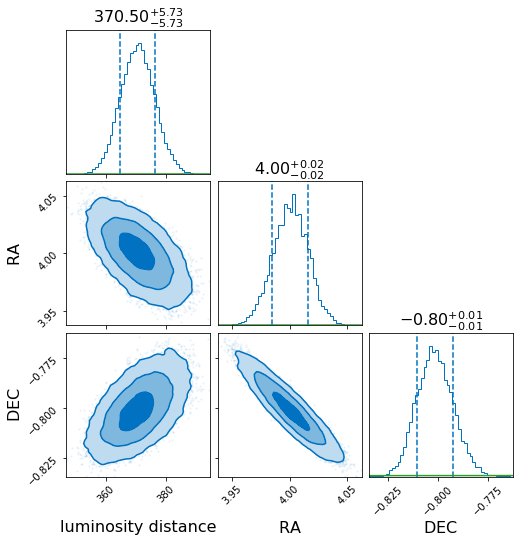

In [13]:
result.plot_corner(parameters=["luminosity_distance", "ra", 'dec'], priors=prior)

In [14]:
result.save_posterior_samples()

14:34 bilby INFO    : Writing samples file to /home/imcmahon/Documents/skymap-inference/data/simlogs/HL1-injection-uniform_posterior_samples.dat


<h2>HEALPix Run</h2>

In [15]:
waveform_arguments = dict(waveform_approximant="IMRPhenomPv2",
                          reference_frequency=50.0,
                          minimum_frequency=minimum_frequency
                         )

waveform_generator = bilby.gw.WaveformGenerator(duration=duration,
                                                sampling_frequency=sampling_frequency,
                                                frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
                                                parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
                                                waveform_arguments=waveform_arguments
                                               )

ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])

ifos.set_strain_data_from_power_spectral_densities(sampling_frequency=sampling_frequency,
                                                   duration=duration,
                                                   start_time=injection_parameters["geocent_time"] - 2
                                                  )

ifos.inject_signal(waveform_generator=waveform_generator, parameters=injection_parameters)

14:34 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
14:34 bilby INFO    : Injected signal in H1:
14:34 bilby INFO    :   optimal SNR = 54.31
14:34 bilby INFO    :   matched filter SNR = 53.96-0.71j
14:34 bilby INFO    :   mass_1 = 30.217311217519367
14:34 bilby INFO    :   mass_2 = 29.438553059882512
14:34 bilby INFO    :   a_1 = 0.7513861074949716
14:34 bilby INFO    :   a_2 = 0.6775246946853614
14:34 bilby INFO    :   tilt_1 = 0.4195402987370333
14:34 bilby INFO    :   tilt_2 = 0.9471592794232708
14:34 bilby INFO    :   phi_12 = 5.605047812344974
14:34 bilby INFO    :   phi_jl = 0.16950619973375008
14:34 bilby INFO    :   luminosity_distance = 373.0783085045788
14:34 bilby INFO    :   theta_jn = 1.9960130340723063
14:34 bilby INFO    :   psi = 0.7922942262461422
14:34 bilby INFO    :   phase

[{'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])},
 {'plus': array([0.-0.j, 0.-0.j, 0.-0.j, ..., 0.-0.j, 0.-0.j, 0.-0.j]),
  'cross': array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])}]

In [17]:
prior = bilby.gw.prior.PriorDict()
for key in ["mass_1",
            "mass_2",
            "a_1",
            "a_2",
            "tilt_1",
            "tilt_2",
            "theta_jn",
            "phi_12",
            "phi_jl",
            "psi",
            "phase",
           ]:
    prior[key] = injection_parameters[key]

prior["luminosity_distance"] = bilby.core.prior.PowerLaw(alpha=2, name='luminosity_distance', minimum=np.min(dl), maximum=1500, unit='Mpc', latex_label='$d_L$')
prior["geocent_time"] = bilby.core.prior.Uniform(injection_parameters['geocent_time']-0.1, injection_parameters['geocent_time']+0.1, name="geocent_time")

hp_prior = bilby.gw.prior.HealPixMapPriorDist('data/catalog_skymap.fits', names=['ra', 'dec'], bounds={'ra': (0, 2*np.pi), 'dec': (-np.pi/2, np.pi/2)})
prior["ra"] = bilby.gw.prior.HealPixPrior(hp_prior, 'ra')
prior["dec"] = bilby.gw.prior.HealPixPrior(hp_prior, 'dec')

likelihood = bilby.gw.GravitationalWaveTransient(interferometers=ifos, waveform_generator=waveform_generator, priors=prior,
                                                 time_marginalization=True, phase_marginalization=False, distance_marginalization=True)

14:36 bilby INFO    : Loaded distance marginalisation lookup table does not match for distance_array.
14:36 bilby INFO    : Building lookup table for distance marginalisation.


  0%|          | 0/400 [00:00<?, ?it/s]

In [18]:
result_hp = bilby.run_sampler(likelihood=likelihood,
                           priors=prior,
                           sampler="dynesty",
                           npoints=2000,
                           injection_parameters=injection_parameters,
                           outdir=outdir,
                           label=name+'-injection-healpix',
                           conversion_function=bilby.gw.conversion.generate_all_bbh_parameters
                          )

14:36 bilby INFO    : Running for label 'HL1-injection-healpix', output will be saved to 'data/simlogs'
14:36 bilby INFO    : Using lal version 7.1.7
14:36 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
14:36 bilby INFO    : Using lalsimulation version 3.1.2
14:36 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.2;Id: 8c3a6977aa553c9a2019ec287a61dc5ee92087b4;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
14:36 bilby INFO    : Search parameters:
14:36 bilby INFO    :   ra = HealPixPrior(dist=HealPixMapPriorDist(hp_file='data/catalog_skymap.fits', names=['ra', 'dec'], bounds={'ra': (0, 6.283185307179586), 'dec': (-1.5707963267948966, 1.5707963267948966)}, distance=False), name='ra', latex_label='$\\mathrm{RA}$', unit=None)
14:36 bilby INFO 

0it [00:00, ?it/s]

14:36 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 2000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 1200, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fdf47b26b20>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5, 'print_method': 'tqdm'}
14:36 bilby INFO    : Checkpoint every check_point_delta_t = 600s
14:36 bilby INFO    : Using dynesty version 1.0.1
14:36 bilby INFO    : Using the b

16:49 bilby INFO    : Sampling time: 2:11:45.421168
16:49 bilby INFO    : Reconstructing marginalised parameters.


  0%|          | 0/32854 [00:00<?, ?it/s]

16:55 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/32854 [00:00<?, ?it/s]

16:55 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/32854 [00:00<?, ?it/s]

16:57 bilby INFO    : Summary of results:
nsamples: 32854
ln_noise_evidence: -11140.992
ln_evidence: -7983.310 +/-  0.110
ln_bayes_factor: 3157.682 +/-  0.110



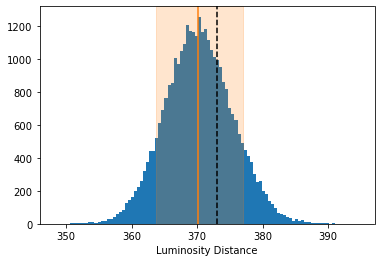

In [19]:
dl = result_hp.posterior["luminosity_distance"].values
lower_bound = np.quantile(dl, 0.1)
upper_bound = np.quantile(dl, 0.9)
median = np.median(dl)
mean = np.mean(dl)
std = np.std(dl)

run_data['hp_dl_med'] = median
run_data['hp_dl_upper'] = upper_bound
run_data['hp_dl_lower'] = lower_bound
run_data['hp_dl_avg'] = mean
run_data['hp_dl_std'] = std

fig, ax = pylab.subplots()
ax.hist(dl, bins=100)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax.axvline(median, color='C1')
ax.axvline(injection_parameters['luminosity_distance'], color='k', linestyle='--')
ax.set_xlabel("Luminosity Distance")
pylab.show()

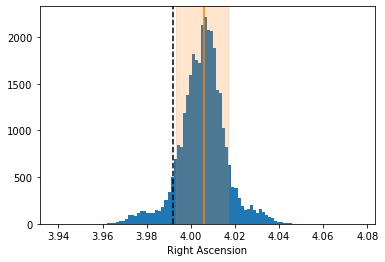

In [20]:
ra = result_hp.posterior["ra"].values
lower_bound = np.quantile(ra, 0.1)
upper_bound = np.quantile(ra, 0.9)
median = np.median(ra)
mean = np.mean(ra)
std = np.std(ra)

run_data['hp_ra_med'] = median
run_data['hp_ra_upper'] = upper_bound
run_data['hp_ra_lower'] = lower_bound
run_data['hp_ra_avg'] = mean
run_data['hp_ra_std'] = std

fig, ax = pylab.subplots()
ax.hist(ra, bins=100)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax.axvline(median, color='C1')
ax.axvline(injection_parameters['ra'], color='k', linestyle='--')
ax.set_xlabel("Right Ascension")
pylab.show()

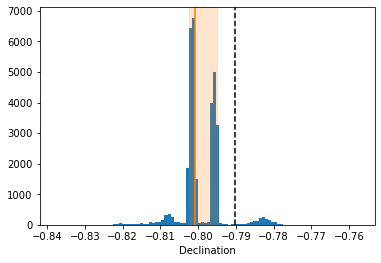

In [21]:
dec = result_hp.posterior["dec"].values
lower_bound = np.quantile(dec, 0.1)
upper_bound = np.quantile(dec, 0.9)
median = np.median(dec)
mean = np.mean(dec)
std = np.std(dec)

run_data['hp_dec_med'] = median
run_data['hp_dec_upper'] = upper_bound
run_data['hp_dec_lower'] = lower_bound
run_data['hp_dec_avg'] = mean
run_data['hp_dec_std'] = std

fig, ax = pylab.subplots()
ax.hist(dec, bins=100)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.2)
ax.axvline(median, color='C1')
ax.axvline(injection_parameters['dec'], color='k', linestyle='--')
ax.set_xlabel("Declination")
pylab.show()

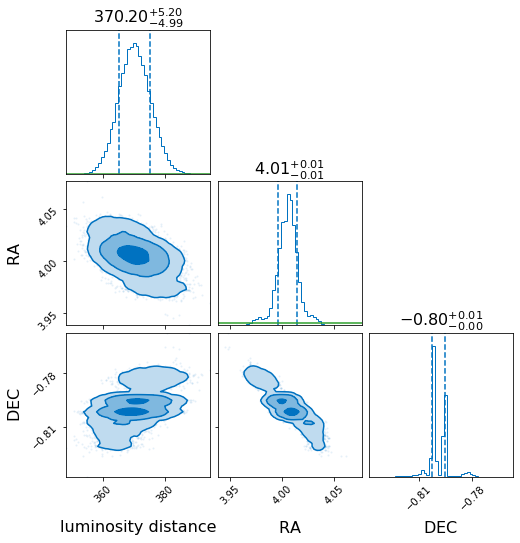

In [22]:
result_hp.plot_corner(parameters=["luminosity_distance", "ra", 'dec'], priors=prior)

In [23]:
result_hp.save_posterior_samples()

16:57 bilby INFO    : Writing samples file to /home/imcmahon/Documents/skymap-inference/data/simlogs/HL1-injection-healpix_posterior_samples.dat


<h2>Save Results</h2>

In [40]:
pd.DataFrame([run_data]).to_csv('data/sim_results.csv', mode='a', index=False, header=False)